In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

print("Fetching main faculty page...")
data = requests.get('https://www.iiserkol.ac.in/web/en/people/faculty/dbs/')
soup = BeautifulSoup(data.content, "html.parser")

# Collecting faculty profile URLs
urls = [link['href'] for link in soup.find_all('a')]
urls = [url for url in urls if '/web/en/people/faculty/dbs/' in url]
link = 'https://www.iiserkol.ac.in'
faculty_websites = list(set([link + url for url in urls]))
print(f"Found {len(faculty_websites)} faculty profile URLs.")

Fetching main faculty page...
Found 27 faculty profile URLs.


In [ ]:
all_data = []
print("Scraping individual faculty pages...")

for faculty_url in faculty_websites:
    try:
        data = requests.get(faculty_url)
        data.raise_for_status()
        soup = BeautifulSoup(data.content, "html.parser")

        # Get faculty name
        name = soup.find_all('h3')
        faculty_name = [name.text for name in name]
        faculty_name = faculty_name[3].strip() if len(faculty_name) > 3 else None

        if not faculty_name:
            print(f"Skipping URL (could not find name): {faculty_url}")
            continue

        print(f"Processing: {faculty_name}")

        # Initialize profile dictionary
        profile_data = {
            "Name": faculty_name,
            "Research Interest": None,
            "Academic Background": None,
            "PhD": None,
            "PhD Year": None,
            "Positions": None,
            "Awards and Honors": None,
            "Number of awards": None,
            "Publications": None,
            "Number of publications": None, # Will be set to 0 later if none found
        }

        # Get main profile content
        content = soup.find_all('div', class_='col-md-12 innerdiv')

        for section in content:
            section_text = section.get_text(separator="\n", strip=True)

            if 'Research Interest:' in section_text:
                profile_data["Research Interest"] = re.sub(r'Research Interest:\s+', '', section_text)

            elif 'Academic Background:' in section_text:
                profile_data["Academic Background"] = re.sub(r'Academic Background:\s+', '', section_text)

                # Try to extract PhD info from this section
                c = re.search(r"\d{4}", section_text) # Look for a 4-digit year
                if c:
                    x = c.start()
                    profile_data["PhD Year"] = section_text[x:x+4]
                    if 'PhD' in section_text or 'phd' in section_text or 'Ph.D' in section_text:
                        phd_text = section_text[21:x-1].strip(" ,")
                        profile_data["PhD"] = phd_text

            elif 'Positions:' in section_text:
                profile_data["Positions"] = re.sub(r'Positions:\s+', '', section_text)

            elif 'Awards and Honors:' in section_text:
                profile_data["Awards and Honors"] = re.sub(r'Awards and Honors:\s+', '', section_text)
                try:
                    award_count = (section_text.count('20') + section_text.count('19') -
                                   section_text.count('2020') - section_text.count('2019'))
                    profile_data["Number of awards"] = award_count
                except Exception:
                    profile_data["Number of awards"] = None # No awards found

        # --- Scrape Publications Page (CORRECTED LOGIC) ---
        try:
            pubs = soup.find_all('a', 'p1')

            for i in pubs:
                pubs_link=(i['href'])
                pubs_link=[faculty_url+'/'+pubs_link]

                for pub_url in pubs_link:
                    data = requests.get(pub_url)
                    soup = BeautifulSoup(data.content, 'html.parser')
                    all_pubs = soup.find_all(class_ ='col-md-12 innerdiv')
                    publications = [all_pubs.text for all_pubs in all_pubs]

                    years = [str(years) for years in range (1900,2026)]
                    years = [years+'."' for years in years]

                    num_of_pubs = 0

                    pubs_str = " ".join(publications)
                    profile_data["Publications"] = re.sub(r'All Publications:\s+', '', pubs_str)

                    for year in years:
                        num_of_pubs += pubs_str.count(year)

            profile_data["Number of publications"] = num_of_pubs

        except Exception as e:
            print(f"Error scraping publications for {faculty_name}: {e}")
            profile_data["Publications"] = None
            profile_data["Number of publications"] = None

        all_data.append(profile_data)

    except requests.exceptions.RequestException as e:
        print(f"Error fetching URL {faculty_url}: {e}")
        continue

print("Scraping complete.")

Scraping individual faculty pages...
Processing: Amit Kumar Mandal
Processing: Rahul Das
Processing: Arnab Gupta
Processing: Robert John Chandran
Processing: Bidisha Sinha
Processing: Rituparna Sinha Roy
Processing: Tapas Kumar Sengupta
Processing: Mohit Prasad
Processing: Neelanjana Sengupta
Processing: Anuradha Bhat
Processing: Sumit Sen Santara
Processing: Dipjyoti Das
Processing: Annagiri Sumana
Processing: Sreeramaiah Gangappa
Processing: Partha Pratim Datta
Processing: Rupak Datta
Processing: Sunil Kumar Khare
Processing: Babu Sudhamalla
Processing: Anindita Bhadra
Processing: Radhika Venkatesan
Processing: Malancha Ta
Processing: Sankar Maiti
Processing: Partho Sarothi Ray
Processing: Supratim Datta
Processing: Amirul Islam Mallick
Processing: Jayasri Das Sarma
Processing: Punyasloke Bhadury
Scraping complete.


In [ ]:
print("Connecting to database and saving data...")
conn = sqlite3.connect("faculty_data.db")
cursor = conn.cursor()

# Drop the table if it already exists
cursor.execute("DROP TABLE IF EXISTS Faculty")

# Create the new table
cursor.execute('''
CREATE TABLE Faculty (
    Name TEXT,
    Research_Interest TEXT,
    Academic_Background TEXT,
    PhD TEXT,
    PhD_Year INTEGER,
    Positions TEXT,
    Awards_and_Honors TEXT,
    Number_of_awards INTEGER,
    Publications TEXT,
    No_of_publications INTEGER
)
''')

# Insert data into the table
for profile in all_data:
    cursor.execute('''
    INSERT INTO Faculty (
        Name, Research_Interest, Academic_Background, PhD, PhD_Year,
        Positions, Awards_and_Honors, Number_of_awards, Publications, No_of_publications
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        profile["Name"],
        profile["Research Interest"],
        profile["Academic Background"],
        profile["PhD"],
        profile["PhD Year"],
        profile["Positions"],
        profile["Awards and Honors"],
        profile["Number of awards"],
        profile["Publications"],
        profile["Number of publications"]
    ))

# Commit changes
conn.commit()
print("Data saved to faculty_data.db")

Connecting to database and saving data...
Data saved to faculty_data.db


In [ ]:
print("Loading data into pandas DataFrame...")
# Read data from SQL back into a pandas DataFrame
df = pd.read_sql_query("SELECT * FROM Faculty", conn)

# Close the database connection
conn.close()

# Define list of Indian locations
Indian_cities = [
    "Adilabad", "Adoni", "Agartala", "Agra", "Ahmedabad", "Ahmednagar", "Aizawl", "Ajmer", "Akola",
"Aligarh", "Allahabad", "Alwar", "Amravati", "Ambattur", "Amritsar", "Anand", "Anantapur",
"Andaman and Nicobar Islands", "Andhra Pradesh", "Arrah", "Arunachal Pradesh", "Asansol",
"Aurangabad", "Aurangabad (Bihar)", "Avadi", "Bally", "Balasore", "Bareilly", "Baramati",
"Baramulla", "Barasat", "Bardhaman", "Baripada", "Barmer", "Bathinda", "Begusarai", "Belgaum",
"Bellary", "Bengaluru", "Berhampur", "Bhagalpur", "Bhavnagar", "Bhilai", "Bhilwara", "Bhiwani",
"Bhopal", "Bhubaneswar", "Bhuj", "Bihar", "Bihar Sharif", "Bijapur", "Bilaspur", "Bilaspur (HP)",
"BITS Goa", "BITS Hyderabad", "BITS Pilani", "Bokaro", "Bombay", "Brahmapur", "Burdwan",
"Calcutta", "Chandigarh", "Chandrapur", "Chapra", "Chennai", "Chhattisgarh", "Chittoor", "Coimbatore",
"Cuddalore", "Cuttack", "Darbhanga", "Darjeeling", "Davanagere", "Dadra and Nagar Haveli and Daman and Diu",
"Dehradun", "Deoghar", "Delhi", "Dewas", "Dhanbad", "Dharwad", "Dhule", "Dibrugarh", "Dindigul",
"Diu", "Dumka", "Durg", "Durgapur", "Eluru", "Erode", "Faridabad", "Farrukhabad", "Firozabad",
"Gandhinagar", "Gaya", "Ghaziabad", "Giridih", "Goa", "Gopalganj", "Gorakhpur", "Gujarat",
"Gulbarga", "Guntur", "Guwahati", "Gwalior", "Hamirpur", "Haldia", "Haldwani", "Hapur", "Haridwar",
"Haryana", "Hazaribagh", "Himachal Pradesh", "Hindupur", "Hoshangabad", "Howrah", "Hubli-Dharwad",
"Hosur", "Hyderabad", "Ichalkaranji", "IIIT Allahabad", "IIIT Hyderabad", "IISc", "IISER Berhampur",
"IISER Bhopal", "IISER Kolkata", "IISER Mohali", "IISER Pune", "IISER Tirupati", "Imphal",
"Indore", "India", "Indian", "Jabalpur", "Jagdalpur", "Jadavpur", "Jaipur", "Jaisalmer", "Jalgaon",
"Jalna", "Jalpaiguri", "Jammu and Kashmir", "Jamnagar", "Jamui", "Jamshedpur", "Jhansi", "Jharkhand",
"Jhunjhunu", "JNU", "Jodhpur", "Junagadh", "Kadapa", "Kakinada", "Kalyan-Dombivli", "Kalyani",
"Kanchipuram", "Kanpur", "Kanyakumari", "Karaikal", "Karimnagar", "Karur", "Karnal", "Karnataka",
"Kathua", "Khammam", "Kharagpur", "Kochi", "Kolhapur", "Kolkata", "Kollam", "Korba", "Kota",
"Kothagudem", "Kozhikode", "Kulti", "Kumbakonam", "Kurnool", "Ladakh", "Lakshadweep", "Latur",
"Loni", "Lovely Professional University", "Lucknow", "Ludhiana", "Machilipatnam", "Madurai", "Madras",
"Mahbubnagar", "Maheshtala", "Malda", "Malegaon", "Mangalore", "Manipal", "Manipur", "Mandi",
"Mathura", "Mau", "Meerut", "Meghalaya", "Moradabad", "Morena", "Mumbai", "Muzaffarnagar",
"Muzaffarpur", "Mysuru", "Nagaland", "Nagpur", "Nainital", "Nanded", "Nashik", "Navi Mumbai",
"Nellore", "New Delhi", "NIT Calicut", "NIT Surathkal", "NIT Trichy", "NIT Warangal", "Nizamabad",
"Noida", "Odisha", "Ongole", "Ozhukarai", "Palakkad", "Panihati", "Panipat", "Parbhani", "Patiala",
"Patna", "Puducherry", "Pune", "Purnia", "Punjab", "Rajasthan", "Raiganj", "Raipur", "Rajahmundry",
"Rajkot", "Ranchi", "Rampur", "Ratlam", "Ratnagiri", "Rewa", "Rishikesh", "Ropar", "Roorkee",
"Rourkela", "Sagar", "Salem", "Samastipur", "Sambalpur", "Sangli", "Satara", "Satna", "Saharanpur",
"Shahjahanpur", "Shimla", "Shillong", "Shimoga", "Sikar", "Silchar", "Siliguri", "Siwan", "Solan",
"Solapur", "Sonipat", "South Dumdum", "Srikakulam", "Srinagar", "SRM Chennai", "Surat", "Tamil Nadu",
"Tanjavur", "Telangana", "Thanjavur", "Thiruvananthapuram", "Thrissur", "Tiruchirappalli", "Tirunelveli",
"Tirupati", "Tiruppur", "Tripura", "Tumkur", "Udaipur", "Ujjain", "Ulhasnagar", "Una", "Uttar Pradesh",
"Uttarakhand", "Vadodara", "Varanasi", "Vasai-Virar", "Vellore", "Vijayawada", "Visakhapatnam",
"Vizianagaram", "VIT Vellore", "Warangal", "Wardha", "West Bengal"

]

# Function to classify PhD institution
def institution(phd_string):
    if phd_string is None:
        return None
    for institute in Indian_cities:
        if institute in str(phd_string):
            return "India"
    return "Abroad"

# Apply the function to create a new column
df['PhD_Institution'] = df['PhD'].apply(institution)

# Create filtered DataFrames for further analysis
df_filtered = df[df['PhD_Institution'].notna()]
df_yrAw = df.dropna(subset=["Number_of_awards", "PhD_Year"])

# Prepare data for potential plotting or curve fitting
years = df_yrAw["PhD_Year"]
Aws = df_yrAw["Number_of_awards"]

print("Analysis complete. DataFrame 'df' is ready.")
print("\nDataFrame Head:")
print(df.head())

print("\nPhD Institution Counts:")
print(df['PhD_Institution'].value_counts())

Loading data into pandas DataFrame...
Analysis complete. DataFrame 'df' is ready.

DataFrame Head:
                   Name                                  Research_Interest  \
0   Partha Pratim Datta  We are studying the molecular basis of Antimic...   
1          Dipjyoti Das  We try to understand how complex behaviors eme...   
2    Punyasloke Bhadury  We study the biological complexity and intrins...   
3  Robert John Chandran  We conduct ecological research at the populati...   
4     Jayasri Das Sarma  My laboratory is involved in the study of neur...   

                                 Academic_Background  \
0  PhD (Molecular Biology), IICB (Jadavpur Univer...   
1  PhD (Physics), IIT Bombay, 2014\nMSc (Physics)...   
2  Ph.D. (Biological Sciences), Plymouth Marine L...   
3  PhD (Tropical Forest Ecology), Centre for Ecol...   
4  PhD (Immunology/Biochemistry), Indian Statisti...   

                                                 PhD  PhD_Year  \
0  PhD (Molecular Biology), I

In [ ]:
# Convert columns to numeric, forcing any errors (like stray text) into 'NaN'
df['PhD_Year'] = pd.to_numeric(df['PhD_Year'], errors='coerce')
df['Number_of_awards'] = pd.to_numeric(df['Number_of_awards'], errors='coerce')
df['No_of_publications'] = pd.to_numeric(df['No_of_publications'], errors='coerce')

# --- Imports ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Already imported, but good practice

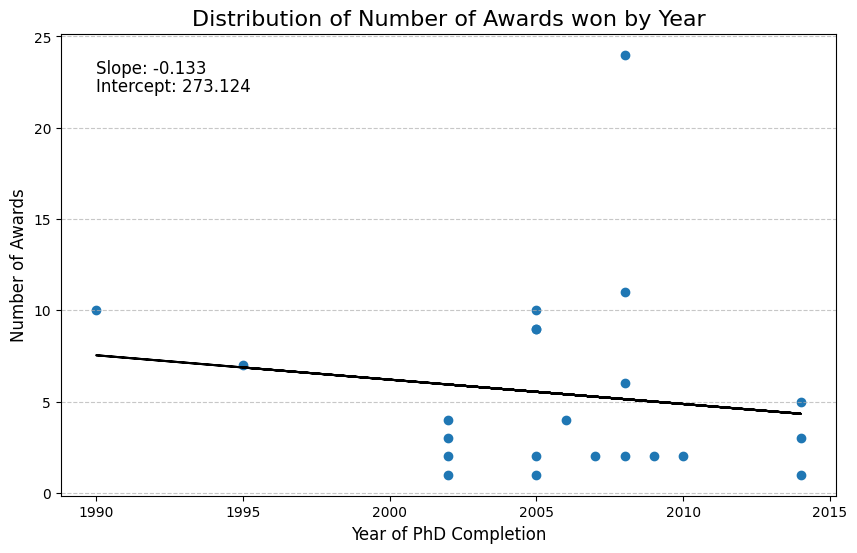

In [ ]:
# Create a DataFrame for this plot, dropping rows with missing data
df_awards_plot = df.dropna(subset=['PhD_Year', 'Number_of_awards'])

# Get the x and y values
x_data = df_awards_plot['PhD_Year']
y_data = df_awards_plot['Number_of_awards']

# --- Plotting ---
plt.figure(figsize=(10, 6)) # Create a new figure
plt.scatter(x_data, y_data) # Create the scatter plot

# --- Calculate and plot the trend line ---
# Fit a 1st-degree polynomial (a straight line)
m, b = np.polyfit(x_data, y_data, 1)

# Plot the line
plt.plot(x_data, m * x_data + b, color='black', alpha=1)

# --- Add labels and title ---
plt.title('Distribution of Number of Awards won by Year', fontsize=16)
plt.xlabel('Year of PhD Completion', fontsize=12)
plt.ylabel('Number of Awards', fontsize=12)

# Add text for slope and intercept [cite: 153, 154]
plt.text(1990, 23, f'Slope: {m:.3f}', fontsize=12)
plt.text(1990, 22, f'Intercept: {b:.3f}', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show() # Display the plot

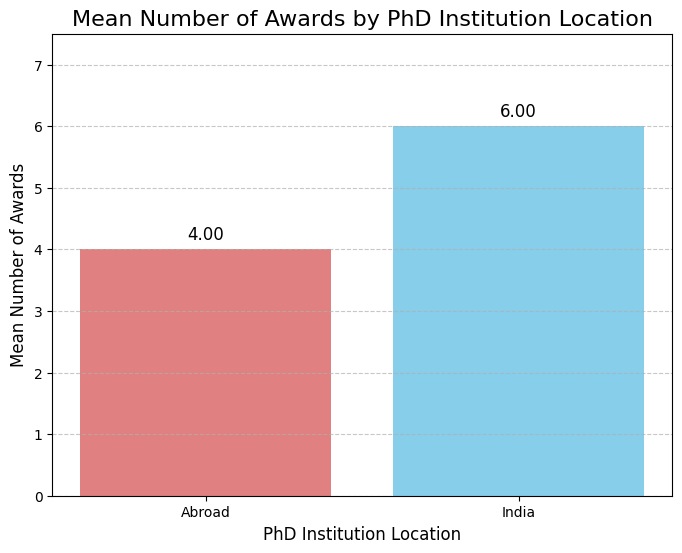

In [ ]:
# Group by institution location and calculate the mean number of awards
mean_awards = df.groupby('PhD_Institution')['Number_of_awards'].mean()

# --- Plotting ---
plt.figure(figsize=(8, 6))
bars = plt.bar(mean_awards.index, mean_awards.values, color=['#E08080', '#87CEEB'])

# --- Add labels and title ---
plt.title('Mean Number of Awards by PhD Institution Location', fontsize=16)
plt.xlabel('PhD Institution Location', fontsize=12)
plt.ylabel('Mean Number of Awards', fontsize=12)

# Add text labels on top of the bars [cite: 185, 186]
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.ylim(0, 7.5) # Set y-axis limit to match the image [cite: 177]
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

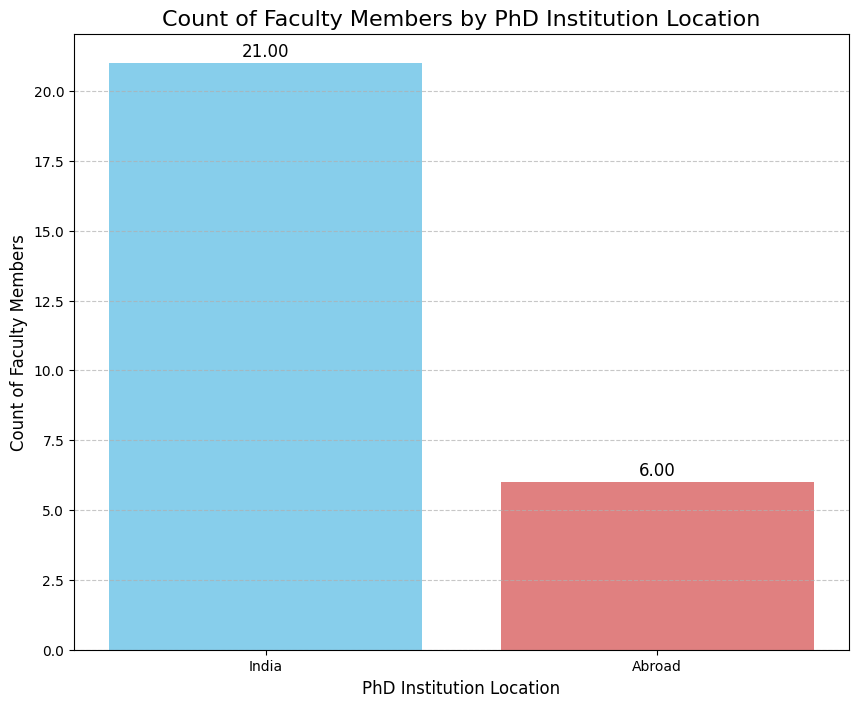

In [ ]:
# Get the counts of faculty from "India" and "Abroad"
location_counts = df['PhD_Institution'].value_counts()

# --- Plotting ---
plt.figure(figsize=(10, 8))
bars = plt.bar(location_counts.index, location_counts.values, color=['#87CEEB', '#E08080'])

# --- Add labels and title ---
plt.title('Count of Faculty Members by PhD Institution Location', fontsize=16)
plt.xlabel('PhD Institution Location', fontsize=12)
plt.ylabel('Count of Faculty Members', fontsize=12)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

# Set y-axis ticks to match the image [cite: 197, 198, 199, 200, 201, 202, 203, 204, 206]
plt.yticks([0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

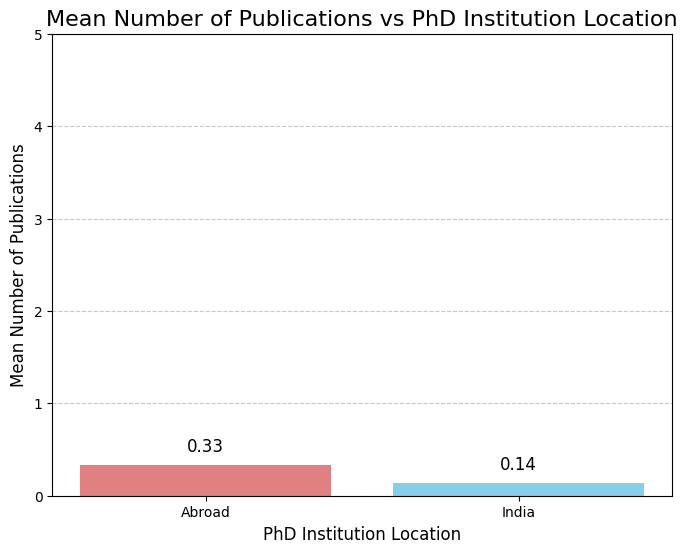

In [ ]:
# Group by institution location and calculate the mean number of publications
mean_pubs = df.groupby('PhD_Institution')['No_of_publications'].mean()

# --- Plotting ---
plt.figure(figsize=(8, 6))
bars = plt.bar(mean_pubs.index, mean_pubs.values, color=['#E08080', '#87CEEB'])

# --- Add labels and title ---
plt.title('Mean Number of Publications vs PhD Institution Location', fontsize=16)
plt.xlabel('PhD Institution Location', fontsize=12)
plt.ylabel('Mean Number of Publications', fontsize=12)

# Add text labels on top of the bars [cite: 220, 221]
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.ylim(0, 5) # Set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

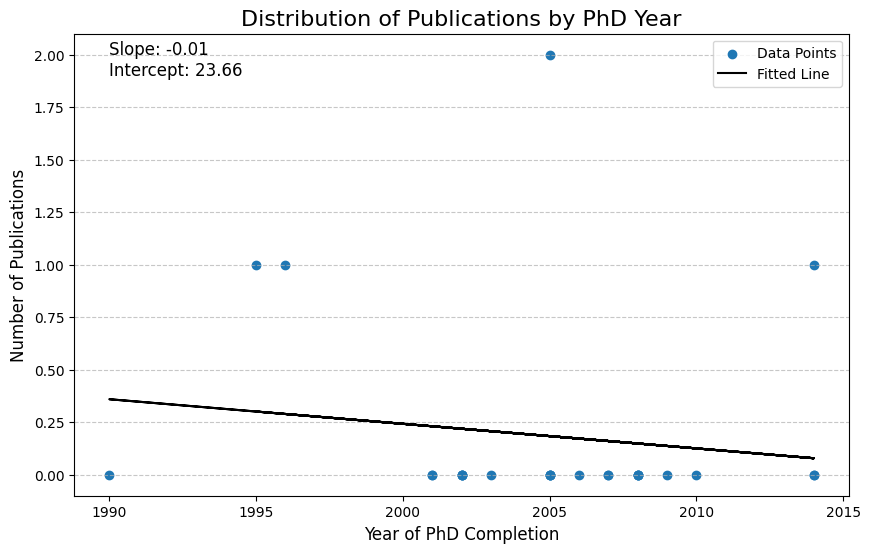

In [ ]:
# Create a DataFrame for this plot, dropping rows with missing data
df_pubs_plot = df.dropna(subset=['PhD_Year', 'No_of_publications'])

# Get the x and y values
x_data_pubs = df_pubs_plot['PhD_Year']
y_data_pubs = df_pubs_plot['No_of_publications']

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.scatter(x_data_pubs, y_data_pubs, label='Data Points') # Create the scatter plot

# --- Calculate and plot the trend line ---
m_pubs, b_pubs = np.polyfit(x_data_pubs, y_data_pubs, 1)
plt.plot(x_data_pubs, m_pubs * x_data_pubs + b_pubs, color='black', alpha=1, label='Fitted Line')

# --- Add labels and title ---
plt.title('Distribution of Publications by PhD Year', fontsize=16)
plt.xlabel('Year of PhD Completion', fontsize=12)
plt.ylabel('Number of Publications', fontsize=12)

# Add text for slope and intercept [cite: 234, 236]
plt.text(1990, 2, f'Slope: {m_pubs:.2f}', fontsize=12)
plt.text(1990, 1.9, f'Intercept: {b_pubs:.2f}', fontsize=12)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

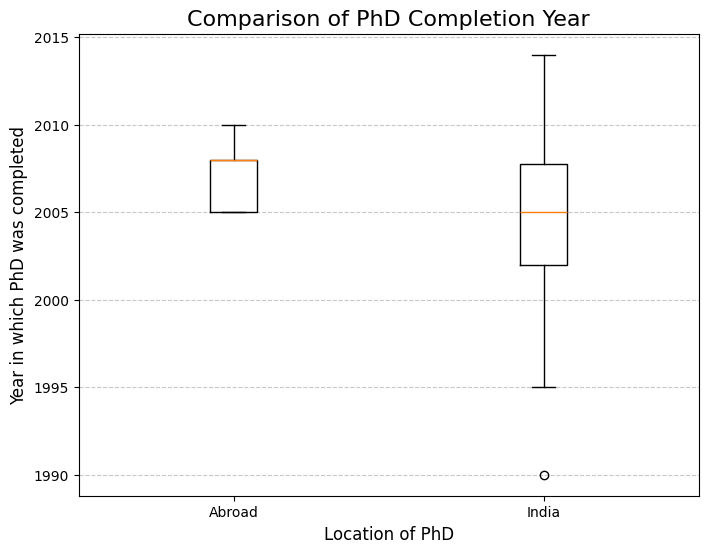

In [ ]:
# Create a list of the two data series to compare
india_years = df[df['PhD_Institution'] == 'India']['PhD_Year'].dropna()
abroad_years = df[df['PhD_Institution'] == 'Abroad']['PhD_Year'].dropna()

data_to_plot = [abroad_years, india_years] # Note: 'Abroad' is first in the image

# --- Plotting ---
plt.figure(figsize=(8, 6))
plt.boxplot(data_to_plot)

# --- Add labels and title ---
plt.title('Comparison of PhD Completion Year', fontsize=16)
plt.xlabel('Location of PhD', fontsize=12)
plt.ylabel('Year in which PhD was completed', fontsize=12)

# Set the x-axis labels to match the data [cite: 283, 284]
plt.xticks([1, 2], ['Abroad', 'India'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()